# **머신러닝실습 두번째 중간고사 대체 과제**

-   **2016270350**
-   **남정재** 

# **0. Drive Mounting**

In [55]:
# 드라이브 마운팅 과정 1
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
# 드라이브 마운팅 과정 2
import os

os.chdir('/content/drive/My Drive/Colab Notebooks/ML_class/transfer_learning')
%pwd

'/content/drive/My Drive/Colab Notebooks/ML_class/transfer_learning'

# **1. Load Data**

In [57]:
# 데이터 로드하고 사이즈 맞춰주기
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './humanhorse_data/' # 데이터셋 다운 경로 지정
print(os.path.join(data_dir, 'train'))
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

print(len(image_datasets['train'])) # train 데이터셋 크기
print(len(image_datasets['val'])) # val 데이터셋 크기

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# GPU 사용 가능하면 GPU 사용, 그렇지 않으면 CPU 사용
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

./humanhorse_data/train
1027
256


# **2. Visualize a few images**

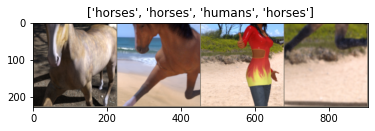

In [58]:
# 데이터 셋이 잘 로드 되었는지 확인하기 위한 약간의 이미지 출력
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# **3. train_model function definition**

In [59]:
# train_model 함수 정의
# train 과정을 함수로 정의
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time() # 시작 시간을 기록(총 소요 시간 계산을 위해)
    
    # pretrained된 모델의 현재 weight값을 best_model_wts에 다 복사해둔다.
    # 모델을 한 번 튜닝할 것이기 때문에 튜닝을 하면 weight값이 바뀐다.
    # weight를 튜닝할 때 성능이 좋으면 그 weight를 계속 저장할 것이다.
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # fine tuning (미세조정) 과정
    for epoch in range(num_epochs): # 에폭 설정하는 과정
        print('Epoch {}/{}'.format(epoch, num_epochs - 1)) # epoch을 카운트
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']: # train mode와 validation mode 순으로 진행
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0 # loss 값 초기화
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward propagation 설정
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'): # train일 때만 gradient계산하라
                    outputs = model(inputs) # forward propagation
                    _, preds = torch.max(outputs, 1) # index읽어서 max값을 가지는 인덱스 pred가져오기
                    loss = criterion(outputs, labels) # loss 계산

                    # backward propagaion 설정
                    # optimize only if in training phase
                    if phase == 'train': # train일 때만
                        loss.backward() # back propagation하고
                        optimizer.step() # gradient descent하기

                    # validation할 때는 forward prop만 한다.

                # statistics
                running_loss += loss.item() * inputs.size(0) # loss값 넣고
                running_corrects += torch.sum(preds == labels.data) # accuracy 계산하는 부분
                
            # scheduler : learning rate를 줄여서 조금씩 내려오게 하는 방법
            if phase == 'train':
                scheduler.step()

            # epoch loss 계산하기
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            # validation할 때마다 loss값의 accuracy를 비교한다.
            # 현재까지의 가장 좋은 accuracy를 누적하고 있는데
            # 지금 모델의 accuracy가 좋으면
            # 그 모델의 weight를 저장한다.
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    
    # 걸린 시간 (몇 분 몇 초) 계산 및 출력
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60)) 
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts) # 가장 좋은 모델 가중치 로드하기
    return model

# **4. visualize_model function definition**

In [60]:
# visualize_model 함수 정의
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    # evaluation
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# **5. Finetuning the convnet**

In [61]:
model_ft = models.vgg16(pretrained=True) # layer가 16개인 vgg 모델 사용

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

# vgg16을 사용했을 때 feature extractor의 마지막 단의 노드 갯수 : 4096 개
# 클래스 갯수 맞춰주기 (아래와 같이 input data에 맞게 2개로 붙여준 것임)
model_ft.fc = nn.Linear(4096, 2)

model_ft = model_ft.to(device) # 모델을 GPU로 보내기

# 손실함수와 Optimizer 정의하기
# cost function 정의하기 (크로스엔트로피 사용)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
# optimizer 정의하기 (SGD 사용)
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
# scheduler로 learning rate를 조금씩 깎아주기
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# **6. Train**

In [62]:
# 모델(model), criterion(loss), optimizer, scheduler, 에폭 갯수
# 모두 정의가 됐으니 모델을 train 시킨다.
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

# 이니셜 값을 그대로 쓰는 것이고
# 뒤에 classifier를 바꾼 것이다.
# 사람과 말 두 개로 분류해야하므로
# linear model를 통해서 2개로 맞춰주었다.
# 위 예시는 freeze 하지 않고 전체를 fine tuning 시켰다.

Epoch 0/24
----------
train Loss: 1.0006 Acc: 0.6504
val Loss: 0.2523 Acc: 0.9336

Epoch 1/24
----------
train Loss: 0.2821 Acc: 0.8841
val Loss: 0.2244 Acc: 0.9258

Epoch 2/24
----------
train Loss: 0.2187 Acc: 0.9163
val Loss: 0.1405 Acc: 0.9375

Epoch 3/24
----------
train Loss: 0.0814 Acc: 0.9737
val Loss: 0.6893 Acc: 0.7891

Epoch 4/24
----------
train Loss: 0.0623 Acc: 0.9766
val Loss: 0.1135 Acc: 0.9453

Epoch 5/24
----------
train Loss: 0.0950 Acc: 0.9688
val Loss: 0.2267 Acc: 0.9414

Epoch 6/24
----------
train Loss: 0.0357 Acc: 0.9834
val Loss: 0.0356 Acc: 0.9883

Epoch 7/24
----------
train Loss: 0.0226 Acc: 0.9932
val Loss: 0.0492 Acc: 0.9805

Epoch 8/24
----------
train Loss: 0.0321 Acc: 0.9883
val Loss: 0.0489 Acc: 0.9766

Epoch 9/24
----------
train Loss: 0.0151 Acc: 0.9922
val Loss: 0.0510 Acc: 0.9805

Epoch 10/24
----------
train Loss: 0.0104 Acc: 0.9971
val Loss: 0.0693 Acc: 0.9766

Epoch 11/24
----------
train Loss: 0.0146 Acc: 0.9942
val Loss: 0.0488 Acc: 0.9844

Ep

# **7. Evaluate**

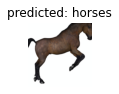

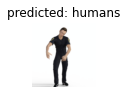

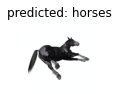

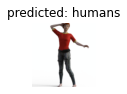

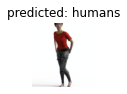

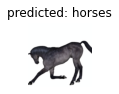

In [63]:
visualize_model(model_ft) # 결과값 중에 일부분 출력하기

plt.ioff()
plt.show()

# **8. Saving & Loading trained model**

In [64]:
# Save model
# 어떤 모델을 만들고 트레이닝을 하고 저장하는 방법
torch.save(model_ft.state_dict(), "namjeongjae.pth")

# Load model
# 저장된 모델을 가져다가 쓰고 싶을 때 가져오는 방법
model_ft.load_state_dict(torch.load("namjeongjae.pth")) 

<All keys matched successfully>